<a href="https://colab.research.google.com/github/depresssed-kid/leaf_segmentation/blob/main/leaf_segm_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm


from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data_path = '/content/drive/MyDrive/kaggle/leaf_seg/data/data'
data_path_im = data_path + '/images'

len_im = len([name for name in os.listdir(data_path_im) if os.path.isfile(os.path.join(data_path_im,name))])
print(len_im)

588


In [3]:
masks = []
images = []

for num_img in range(len_im):
  number_str = str(num_img)
  num_zeros = 5 - len(number_str)
  cur_num = "0"*num_zeros +number_str

  mask = cv2.imread(data_path + "/masks/"  + cur_num+'.png', cv2.IMREAD_COLOR)
  image = cv2.imread(data_path + "/images/"  + cur_num+'.jpg', cv2.IMREAD_COLOR)
  image = cv2.resize(image,(256,256))[:, :, ::-1]
  mask = cv2.resize(mask,(256,256))[:, :, ::-1]

  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  image = np.asarray(image)
  mask = np.asarray(mask)
  masks.append(mask)
  images.append(image)


masks = np.asarray(masks)
images = np.asarray(images)
print(f'labels shape: {masks.shape}')
print(f'images shape: {images.shape}')

labels shape: (588, 256, 256)
images shape: (588, 256, 256, 3)


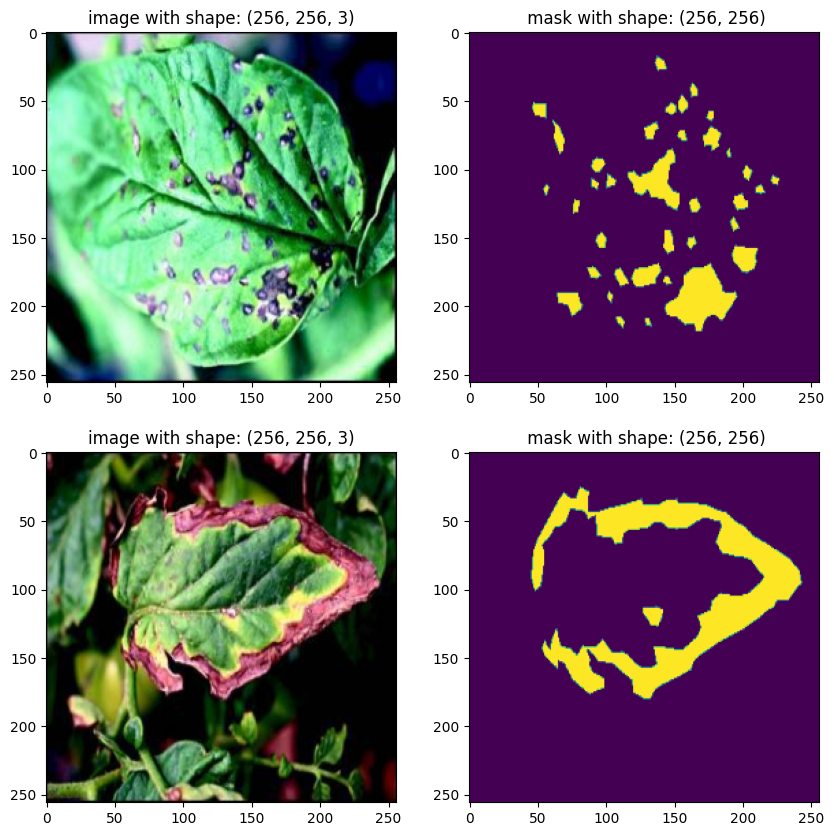

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
  axs[i,0].set_title(f'image with shape: {images[i].shape}')
  axs[i,0].imshow(images[i])

  axs[i,1].set_title(f' mask with shape: {masks[i].shape}')
  axs[i,1].imshow(masks[i])
plt.show()

In [5]:
class DataSet():
  def __init__(self, images, masks, transform = None, mask_transforms = None):
    """
    Inputs:
      images - array of images
      masks - array of true masks for images
      transform - torchvision.transforms object for image preprocessing
    """
    self.image = images
    self.mask = masks
    self.transform = transform
    self.mask_transforms = mask_transforms

  def __getitem__(self, index):
      image = self.transform(self.image[index])
      mask = self.mask_transforms(self.mask[index])

      if self.transform:
          image = self.transform(image)
      if self.mask_transforms:
          mask = self.mask_transforms(mask)

      return image, mask


  def __len__(self):
    return len(self.image)

In [6]:
X_train, X_res, y_train, y_res = train_test_split(images, masks, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_res, y_res, test_size=0.5, random_state=42)


DATA_MEANS = (X_train / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (X_train / 255.0).std(axis=(0, 1, 2))

print(f'train size: {len(X_train)} test size: {len(X_test)} val size: {len(X_val)} ')

train size: 411 test size: 88 val size: 89 


In [7]:
resize = (256,256)

transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])
transform_mask = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize(resize),
    transforms.ToTensor(),

])


In [8]:
train_dataset = DataSet(X_train,
                        y_train,
                        transform,
                        transform_mask
                        )

val_dataset = DataSet(X_val,
                        y_val,
                        transform,
                        transform_mask
                      )
test_dataset = DataSet(X_test,
                        y_test,
                        transform,
                        transform_mask
                      )

In [18]:
BATCH_SIZE = 10
patience = 10
num_epochs = 100
learning_rate = 0.0003
pos_weight = torch.tensor([50.0])

In [10]:
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = 1,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                            batch_size = 1,
                            shuffle = False,
                            num_workers = NUM_WORKERS)

In [11]:
class Block(nn.Module):
	def __init__(self, in_c, out_c):
		super().__init__()

		self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
		self.bn1 = nn.BatchNorm2d(out_c)
		self.relu = nn.ReLU()
		self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
		self.bn2 = nn.BatchNorm2d(out_c)

	def forward(self, x):
		x = self.conv1(x)
		x = self.bn1(x)
		x = self.relu(x)
		x = self.conv2(x)
		x = self.bn2(x)
		return x

In [12]:
class Encoder(nn.Module):
	def __init__(self, chs):
		super().__init__()

		self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
		self.pool = nn.MaxPool2d((2, 2))

	def forward(self, x):
		out = []
		for block in self.enc_blocks:
			x = block(x)
			out.append(x)
			x = self.pool(x)
		return out , x

In [13]:
class Decoder(nn.Module):
    def __init__(self, chs):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 3, 3) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [20]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(256,256)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs, x = self.encoder(x)
        out = self.decoder(x, enc_ftrs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [15]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device)#.unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            #print(preds.sum())
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    return num_correct/num_pixels

In [25]:
unet = UNet(enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(256,256)).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(unet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=7)

total_step = len(train_dataloader)
total_step_test = len(val_dataloader)

best_loss = float('inf')

test_losses = []
train_losses = []
test_accuracies = []
train_accuracies = []


for epoch in range(num_epochs):
    unet.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = unet(images)


        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(scheduler.get_last_lr())
    unet.eval()
    val_loss = check_accuracy(val_dataloader, unet, device=device)
    scheduler.step(val_loss)



    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        break

[0.0003]


100%|██████████| 89/89 [00:04<00:00, 19.00it/s]

Got 4446430/5832704 with pixel accuracy 76.23
Dice score: 3.64


[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.91it/s]

Got 4031371/5832704 with pixel accuracy 69.12
Dice score: 4.53


[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.91it/s]


Got 4342016/5832704 with pixel accuracy 74.44
Dice score: 4.37
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.98it/s]


Got 3528234/5832704 with pixel accuracy 60.49
Dice score: 4.26
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.98it/s]


Got 3928437/5832704 with pixel accuracy 67.35
Dice score: 4.40
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.86it/s]

Got 4287847/5832704 with pixel accuracy 73.51
Dice score: 4.79


[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.91it/s]


Got 3634741/5832704 with pixel accuracy 62.32
Dice score: 4.55
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.73it/s]


Got 4428274/5832704 with pixel accuracy 75.92
Dice score: 4.66
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.76it/s]

Got 4707543/5832704 with pixel accuracy 80.71
Dice score: 2.86


[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.93it/s]


Got 4543851/5832704 with pixel accuracy 77.90
Dice score: 4.14
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.82it/s]


Got 3611313/5832704 with pixel accuracy 61.91
Dice score: 4.25
[0.0003]


100%|██████████| 89/89 [00:04<00:00, 18.82it/s]

Got 4714946/5832704 with pixel accuracy 80.84
Dice score: 1.63


[2.9999999999999997e-05]


100%|██████████| 89/89 [00:04<00:00, 18.91it/s]

Got 4591930/5832704 with pixel accuracy 78.73
Dice score: 4.57


[2.9999999999999997e-05]


100%|██████████| 89/89 [00:04<00:00, 18.91it/s]


Got 4294291/5832704 with pixel accuracy 73.62
Dice score: 5.06


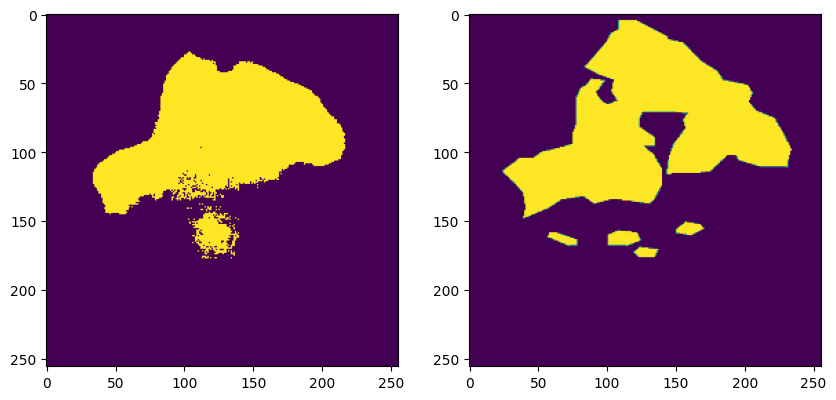

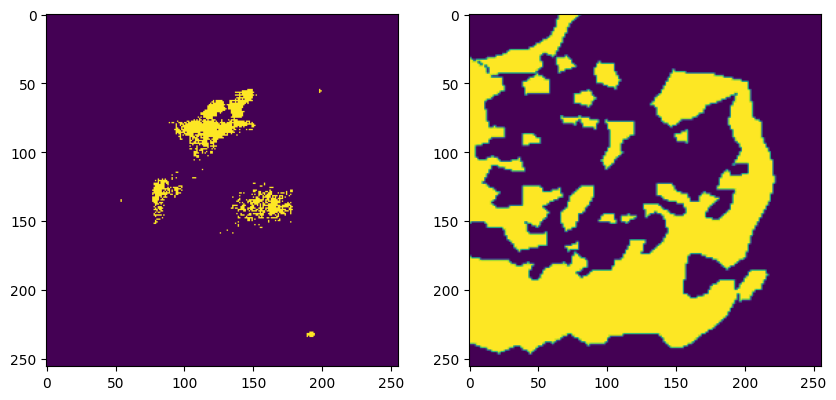

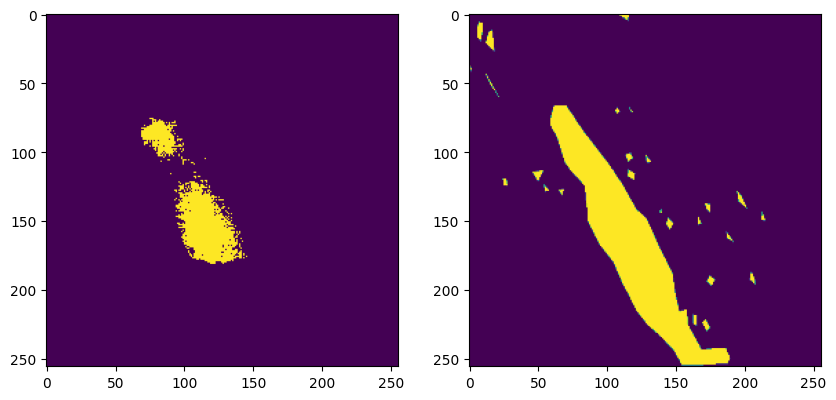

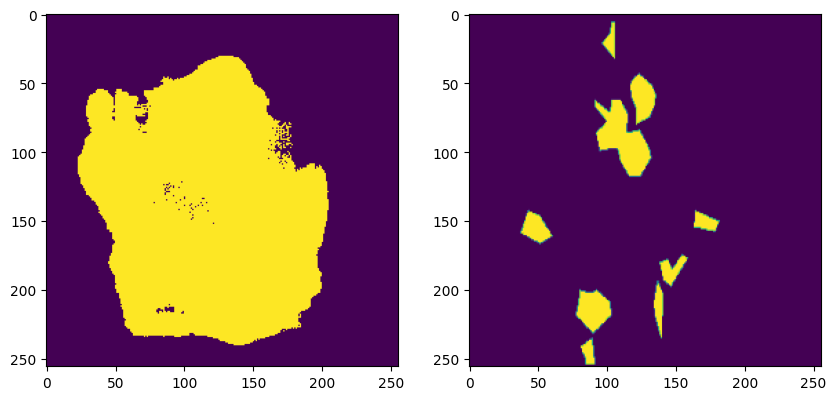

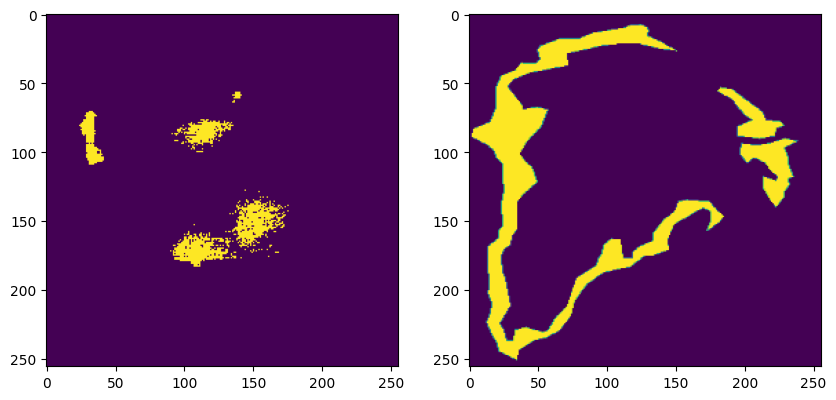

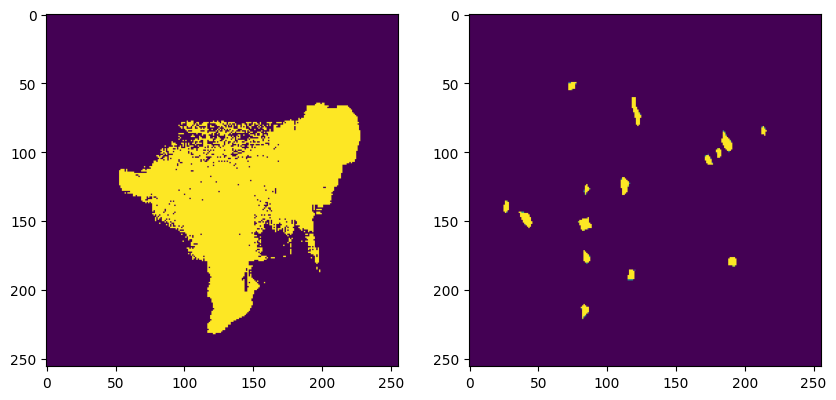

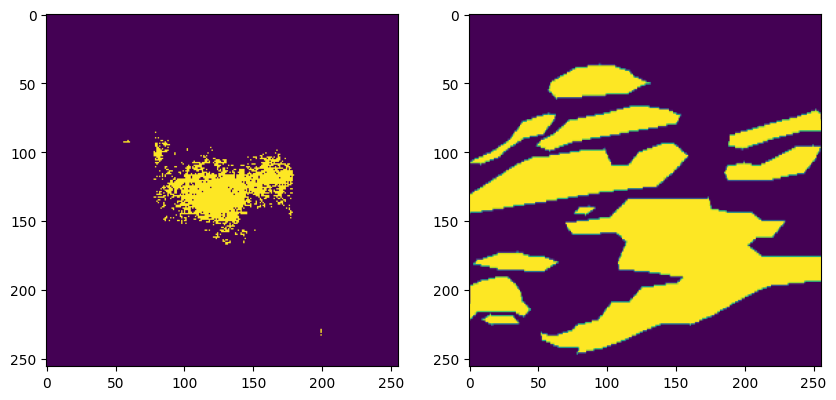

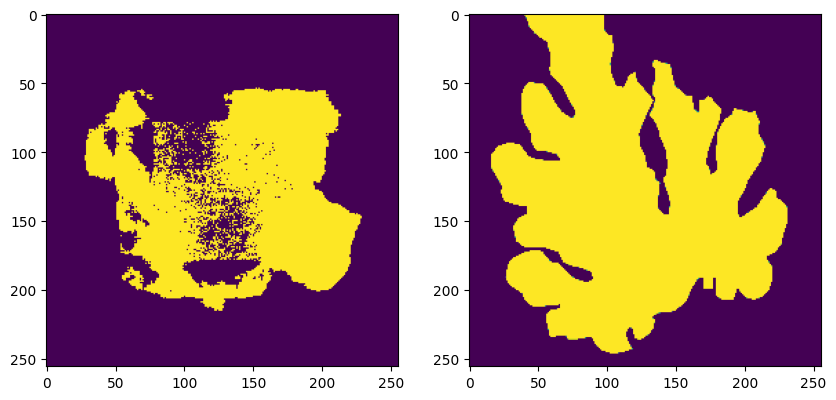

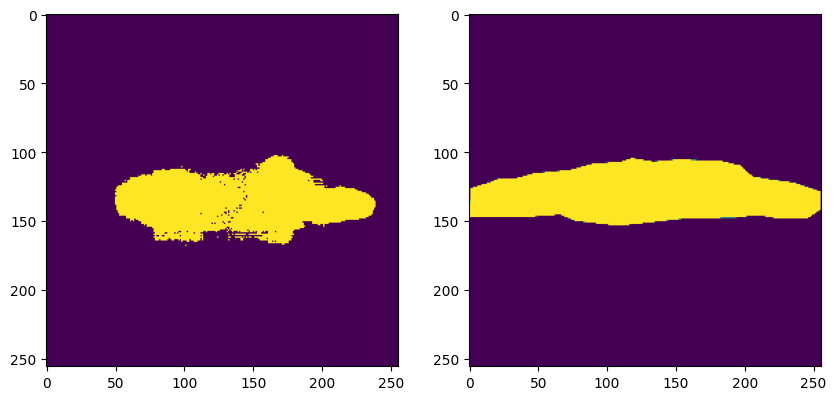

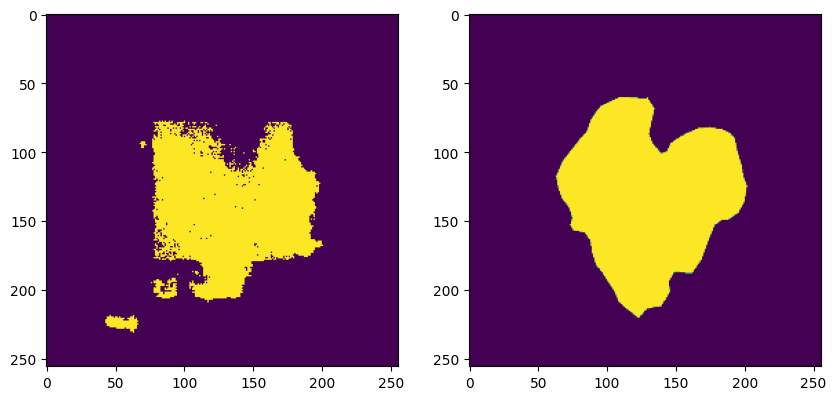

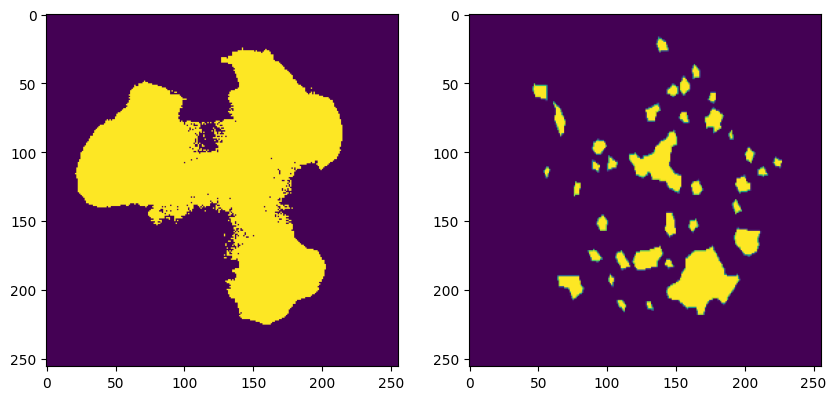

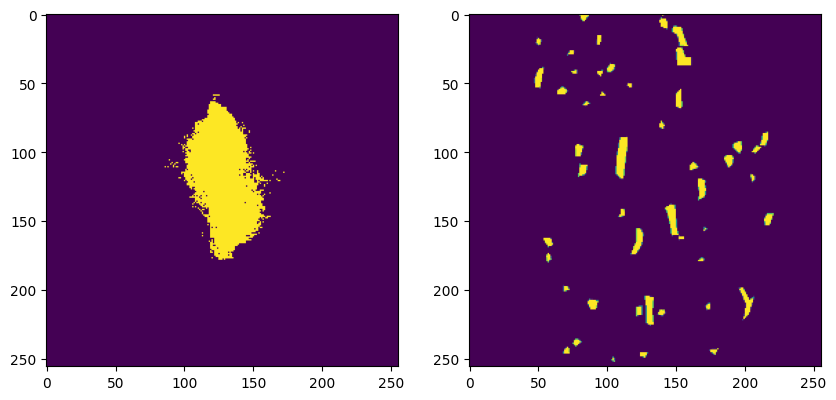

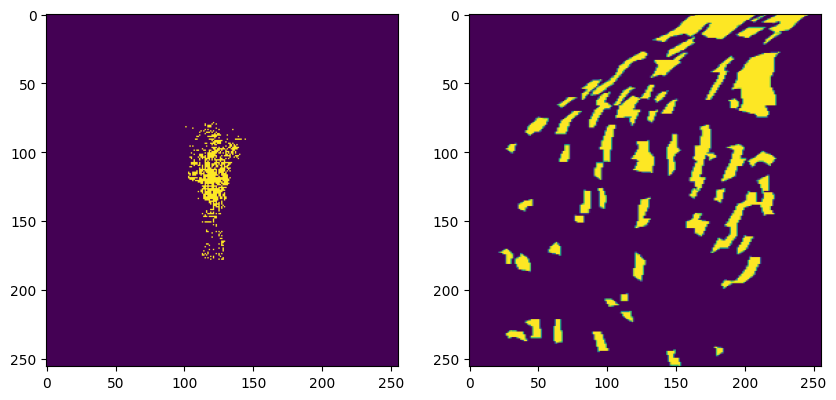

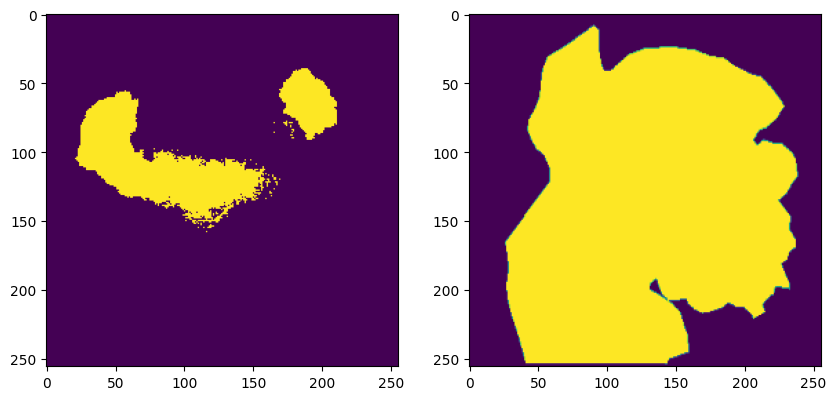

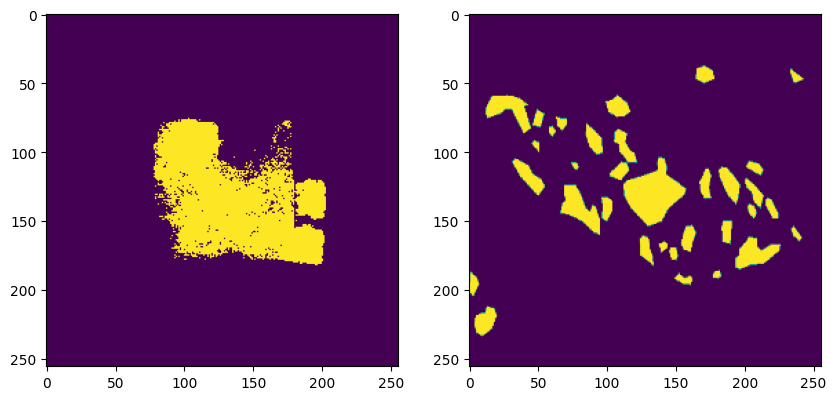

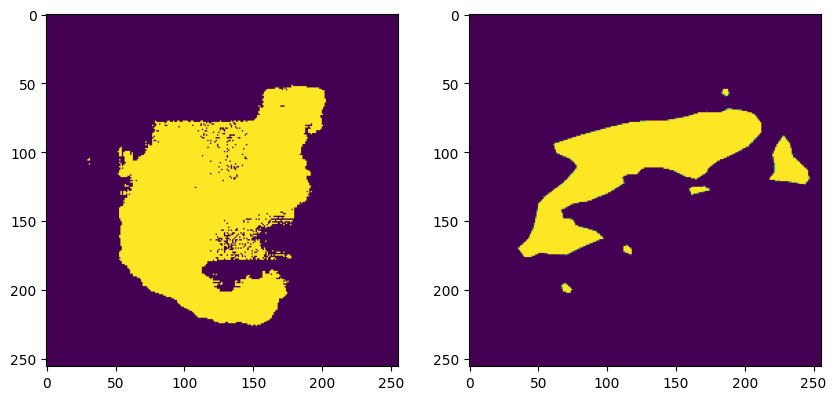

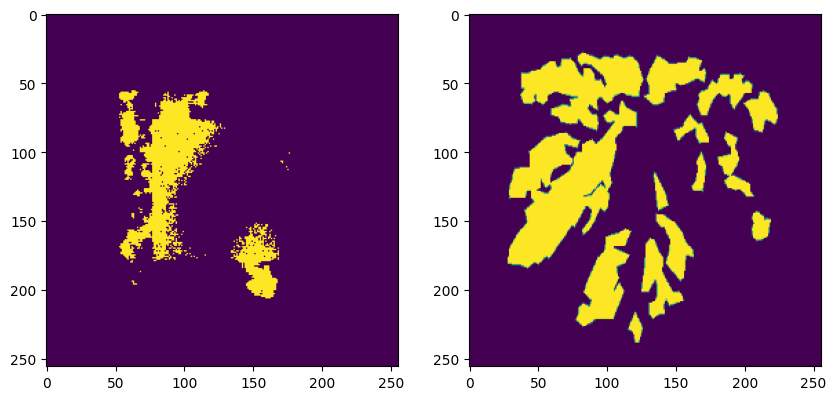

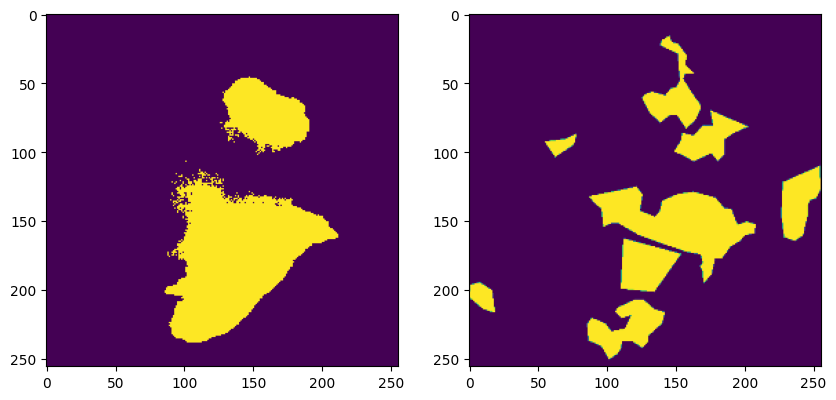

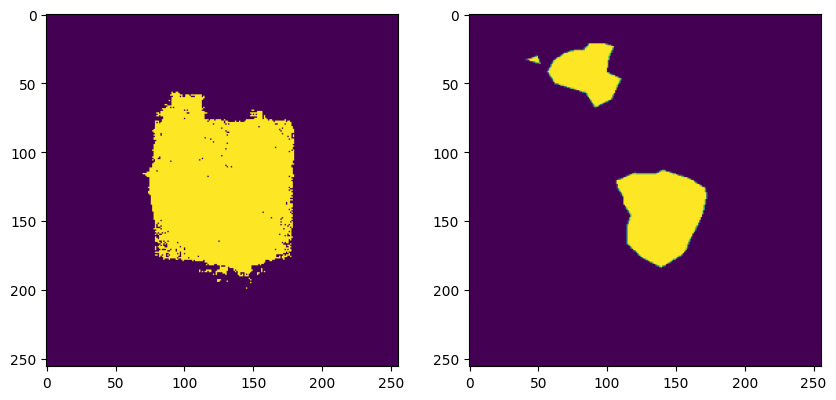

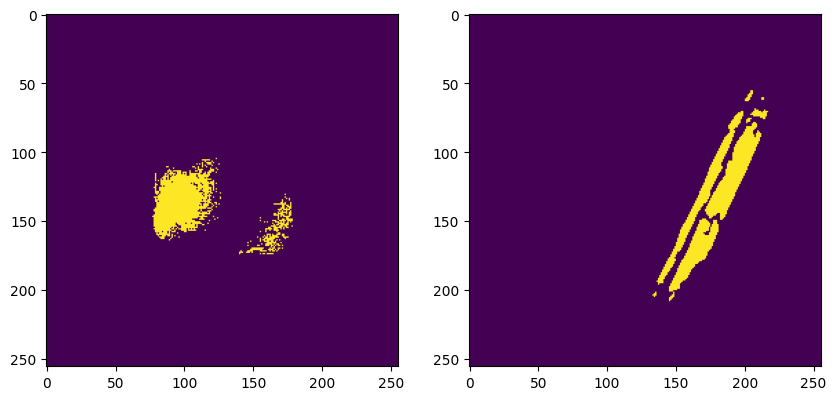

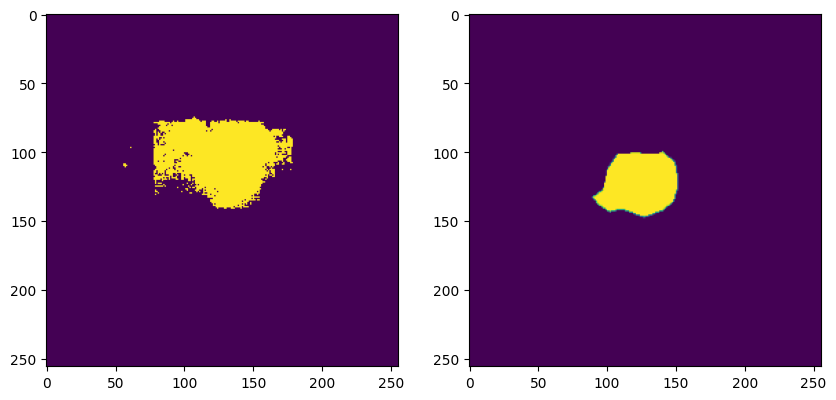

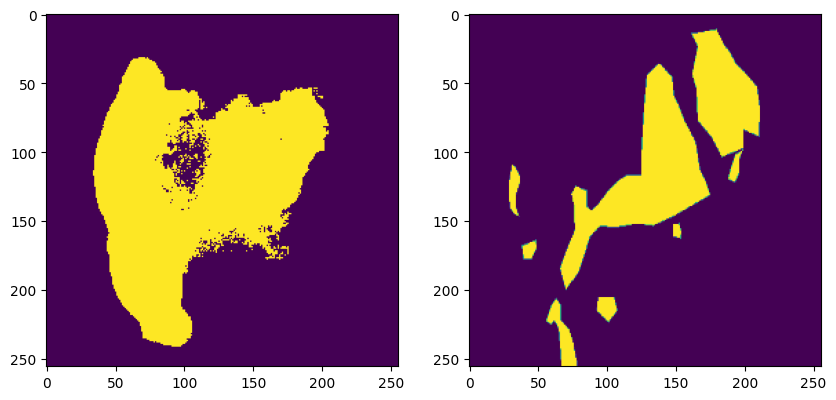

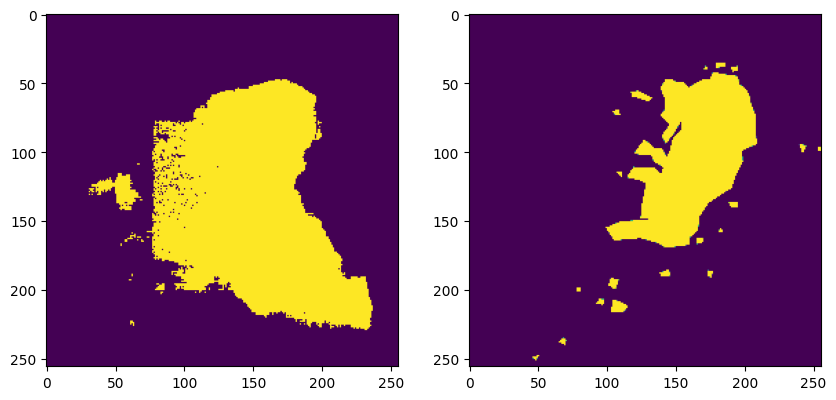

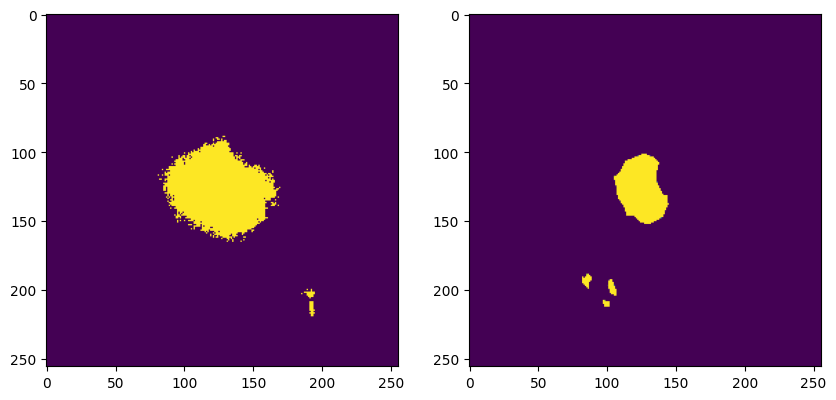

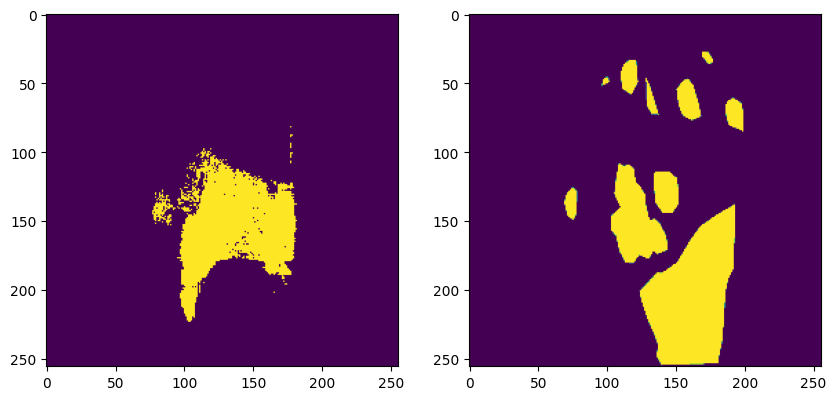

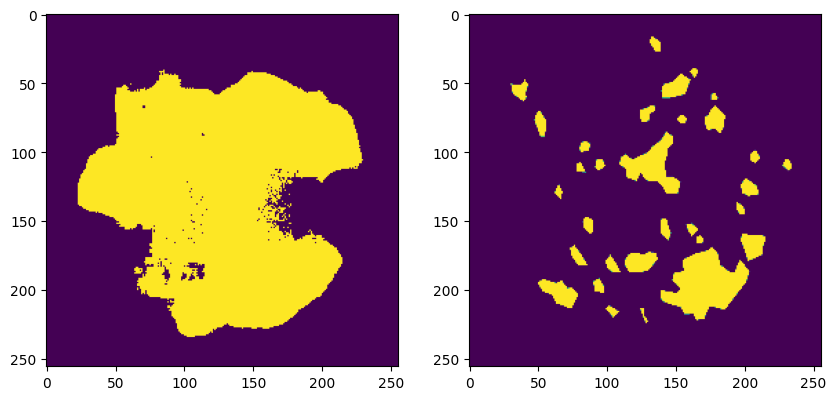

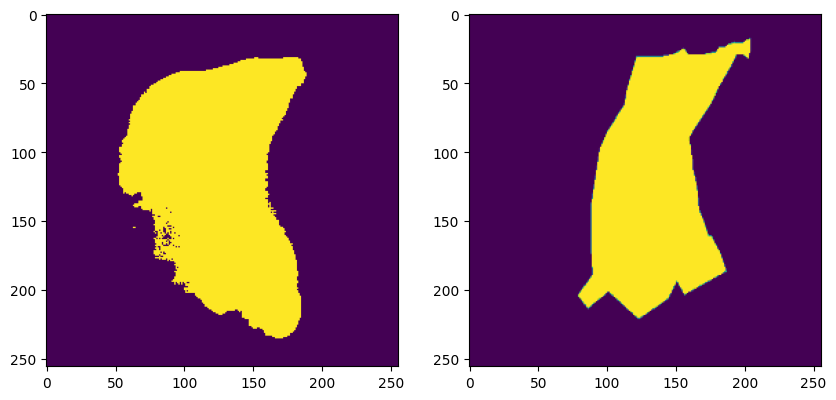

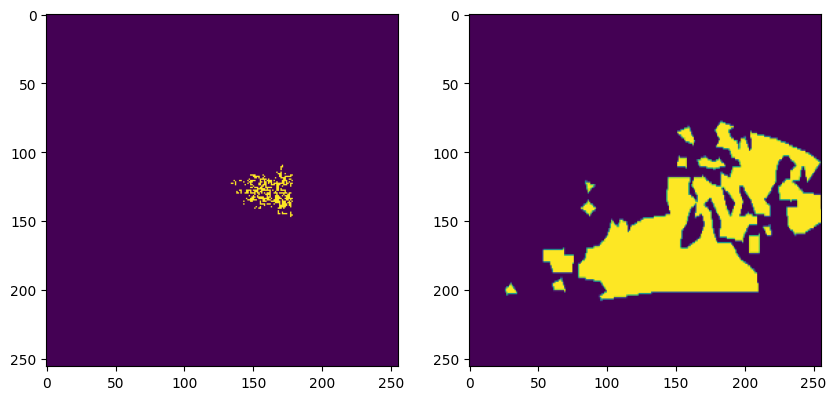

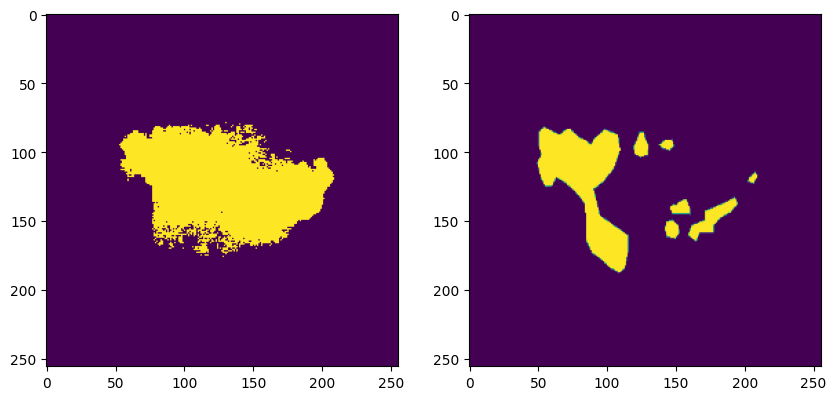

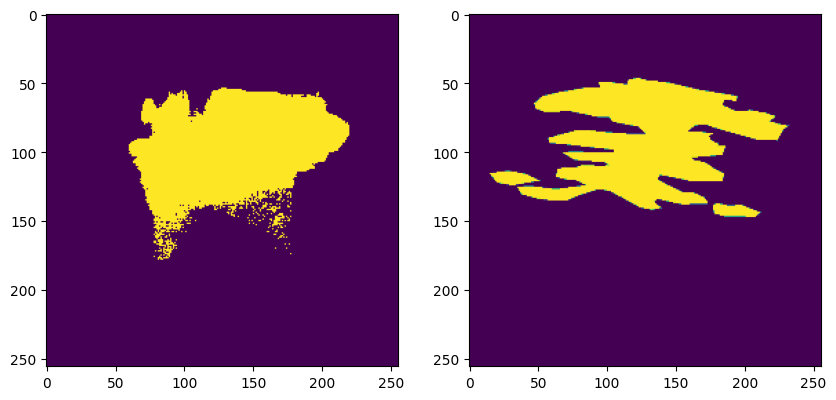

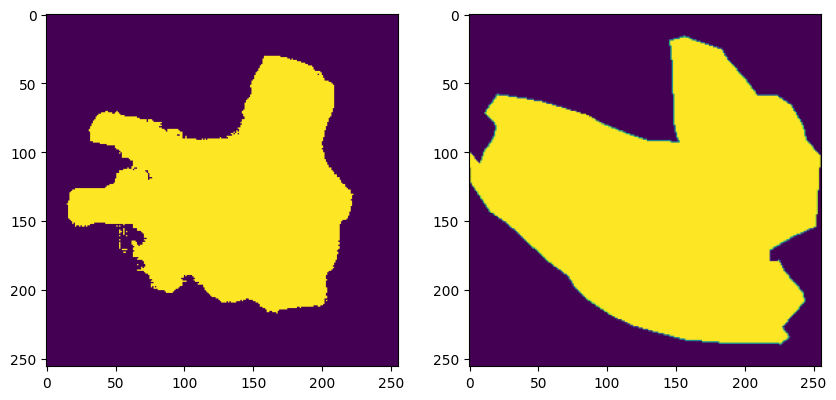

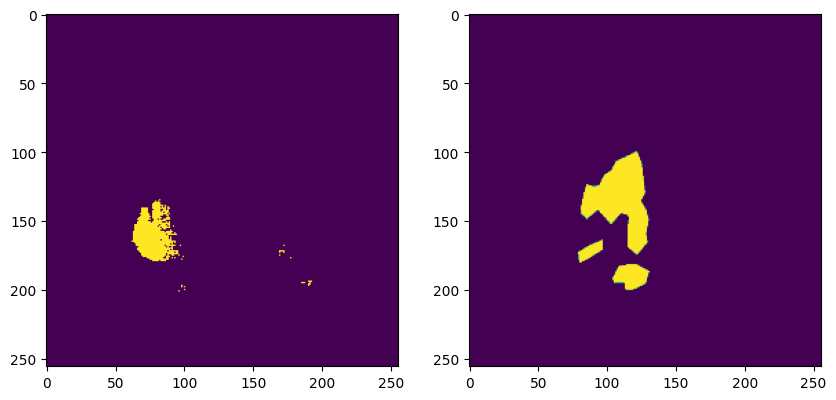

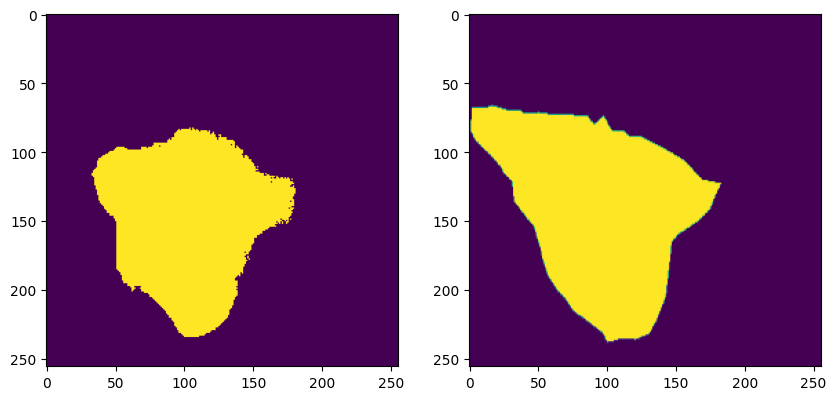

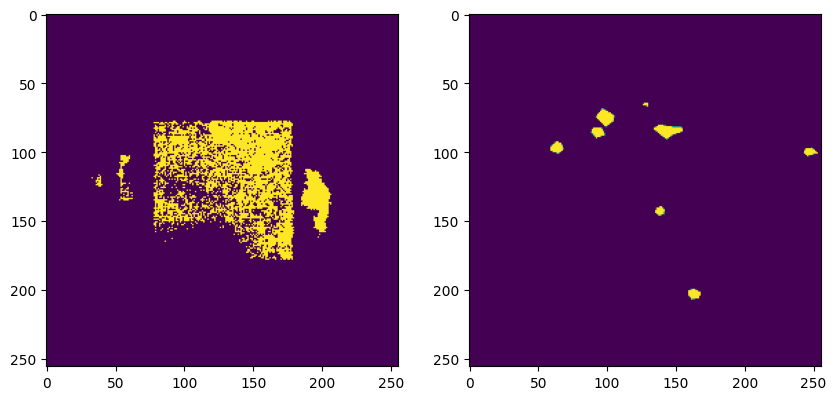

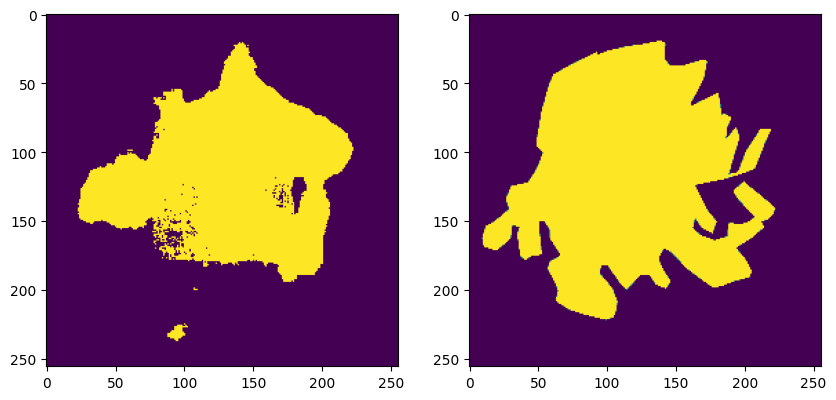

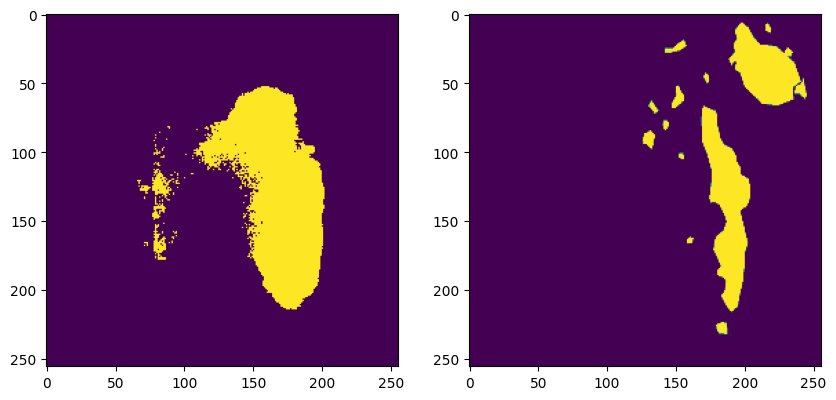

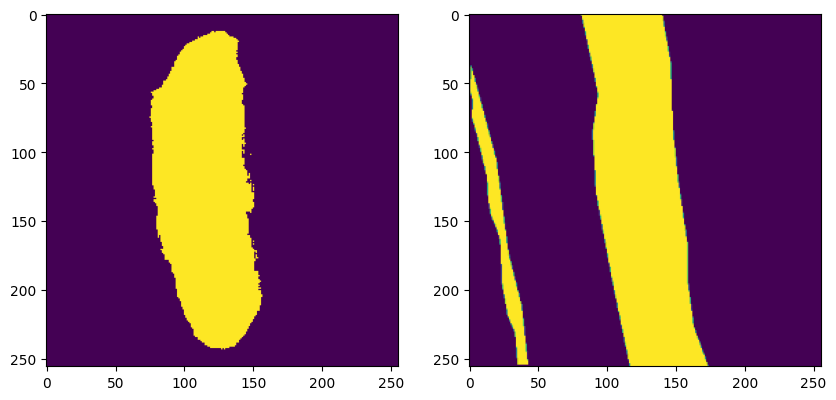

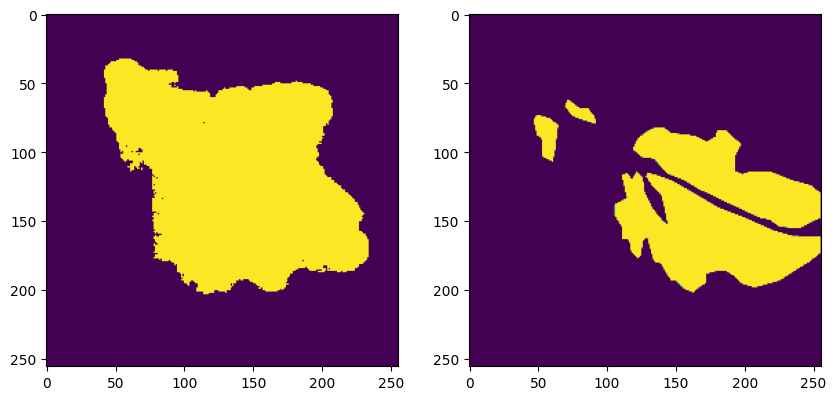

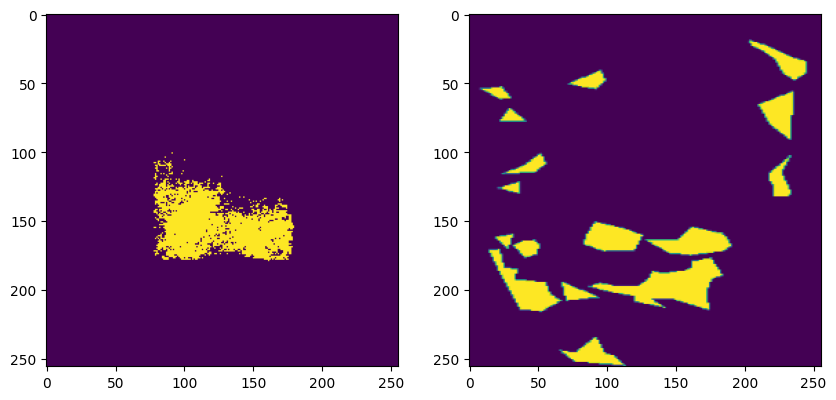

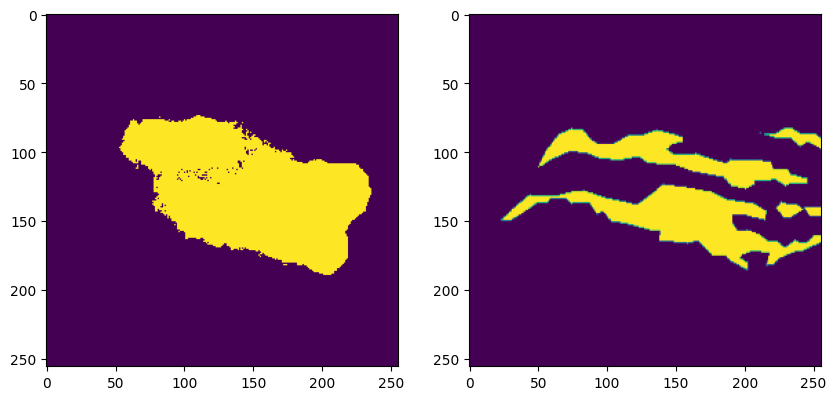

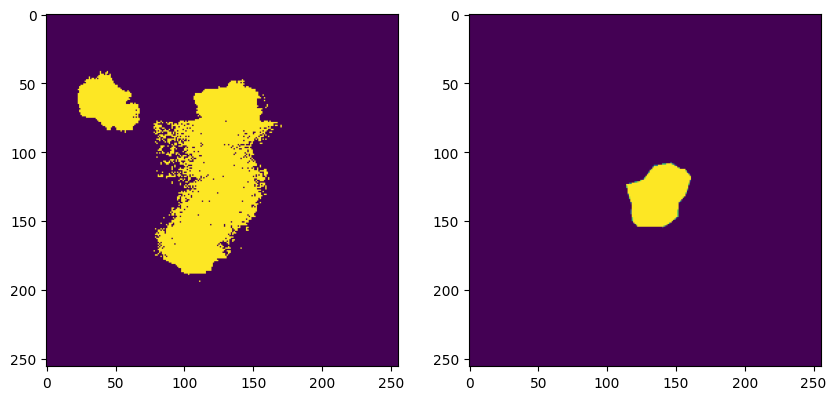

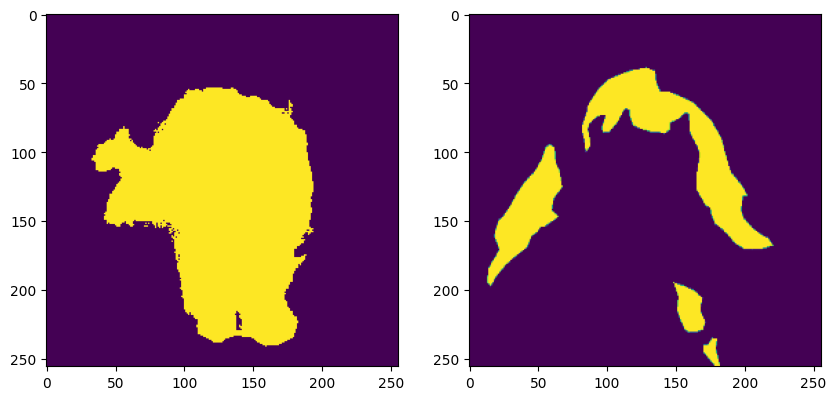

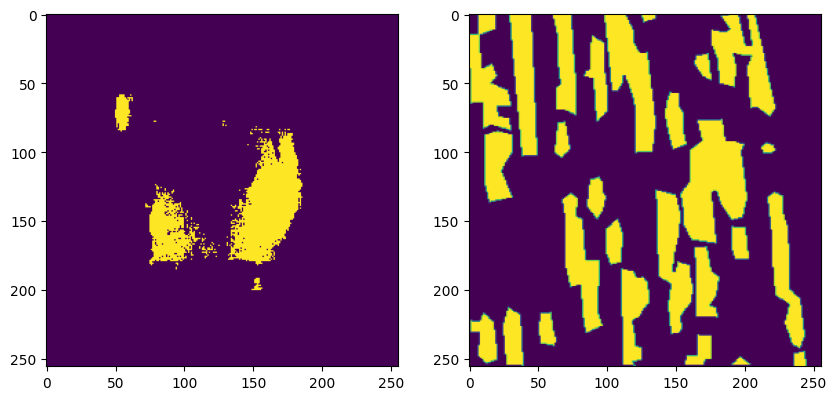

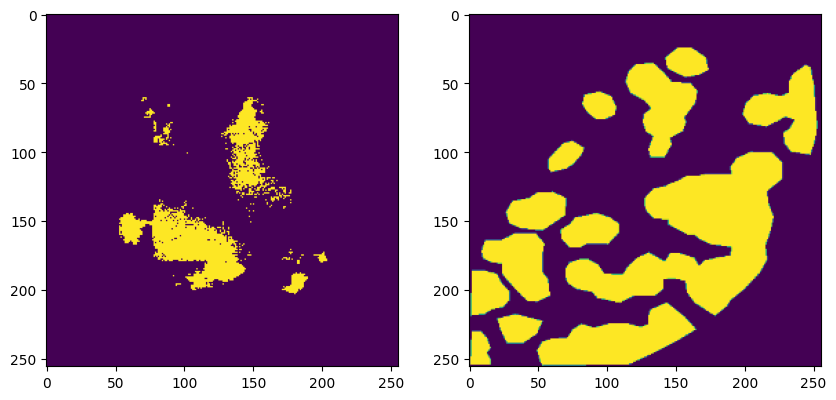

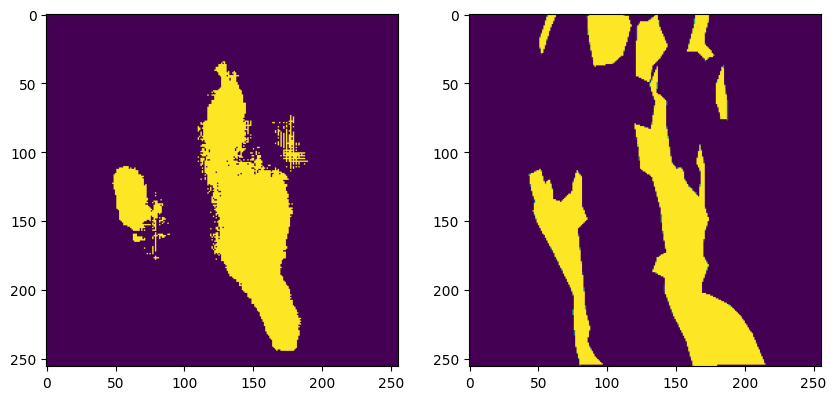

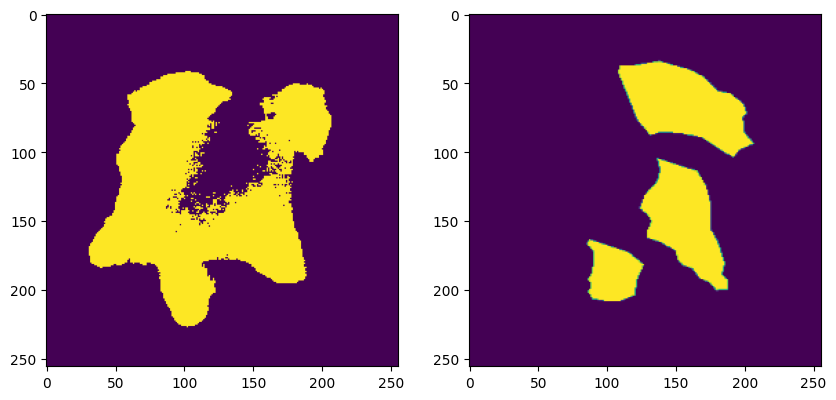

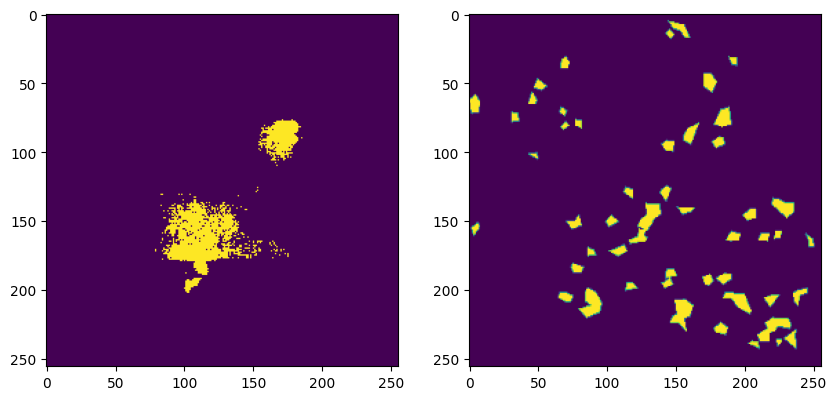

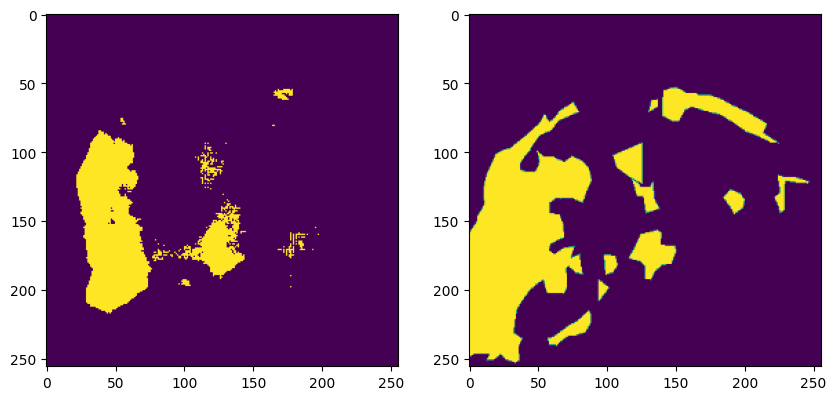

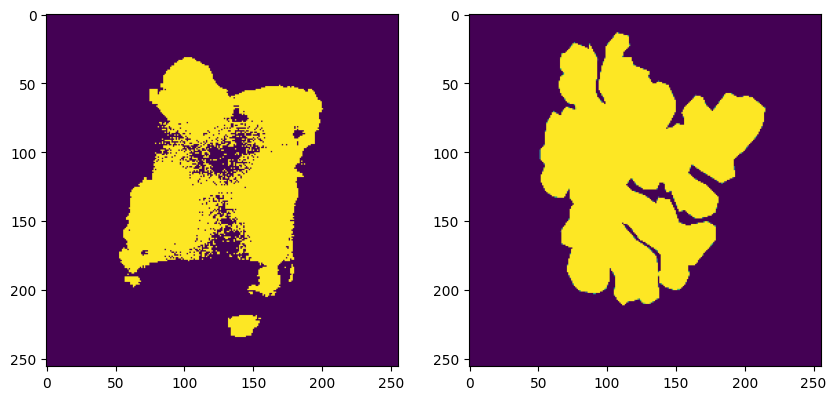

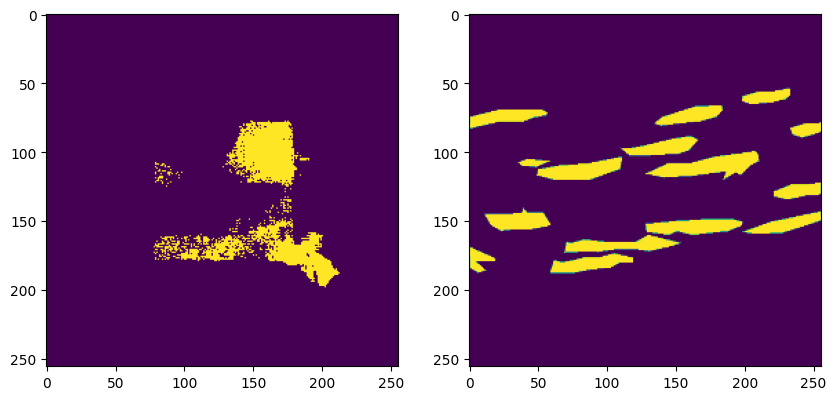

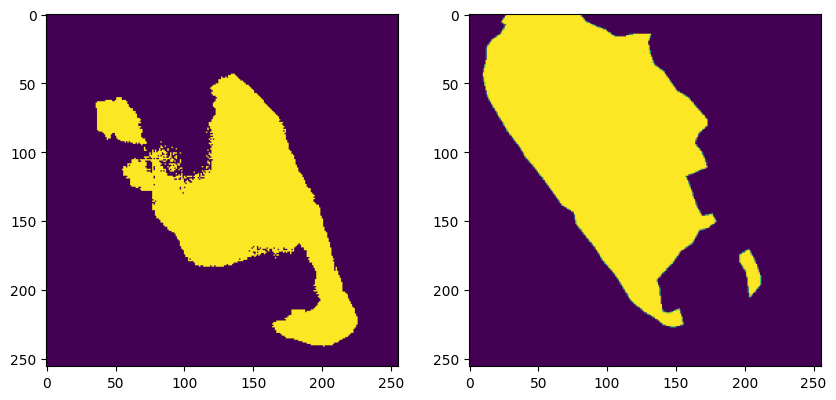

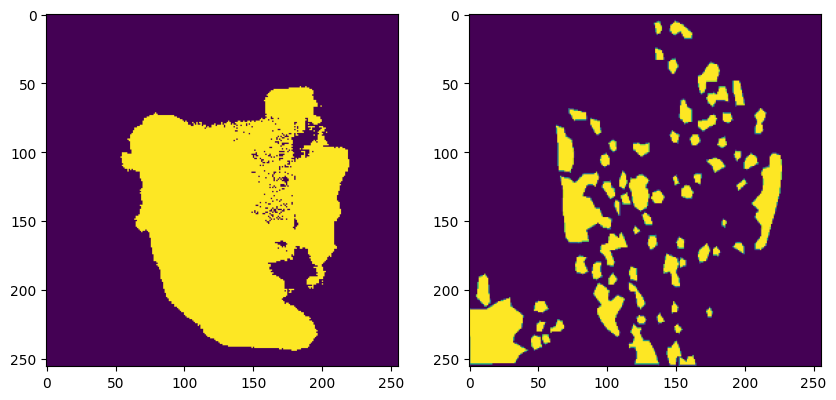

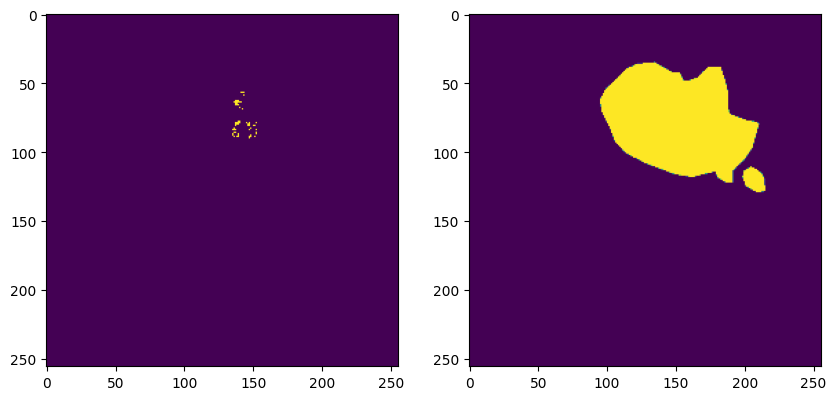

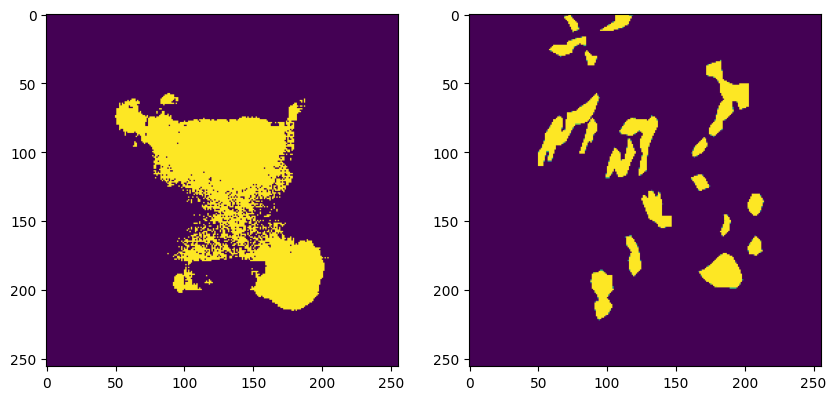

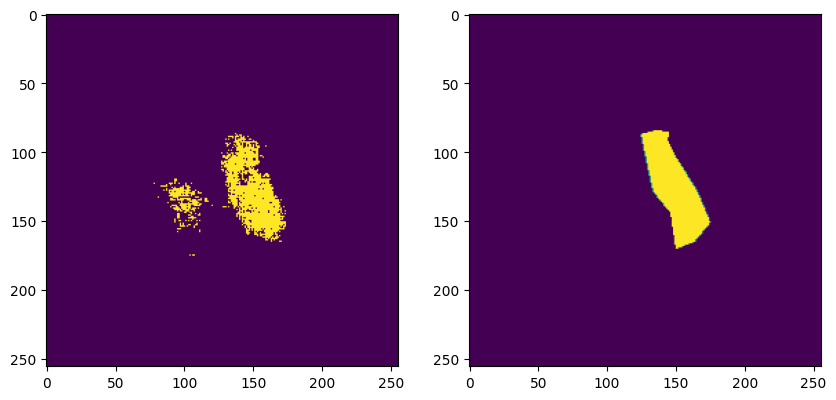

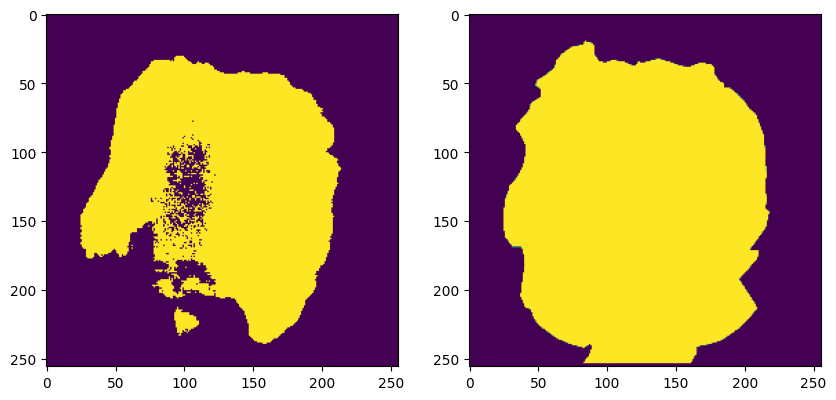

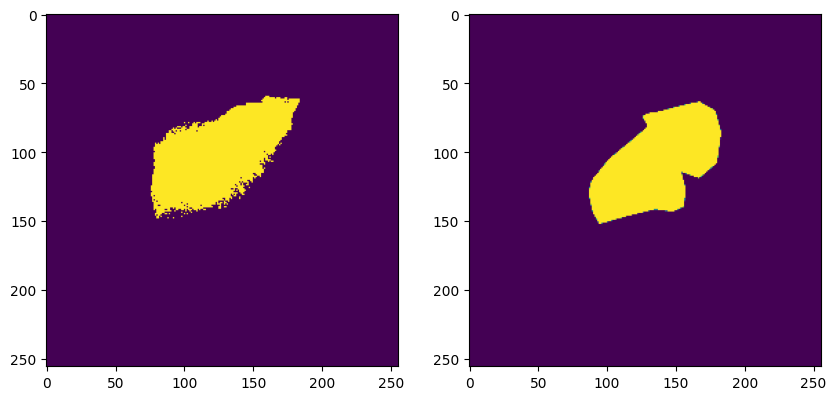

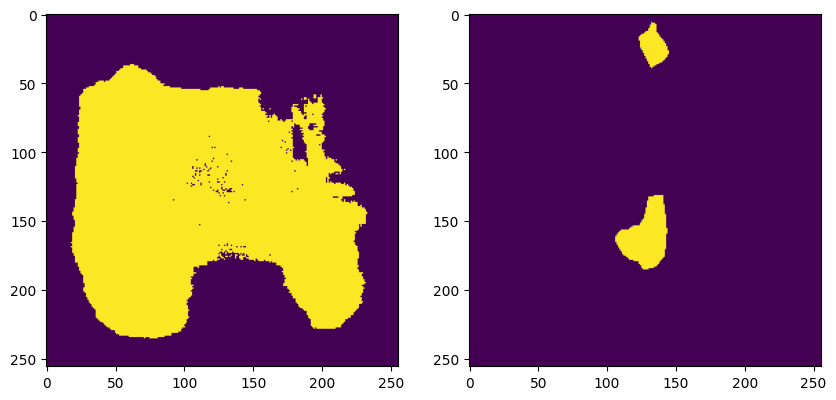

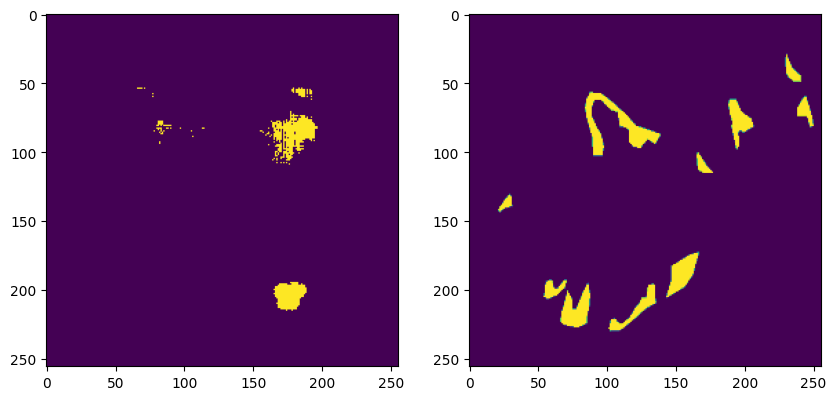

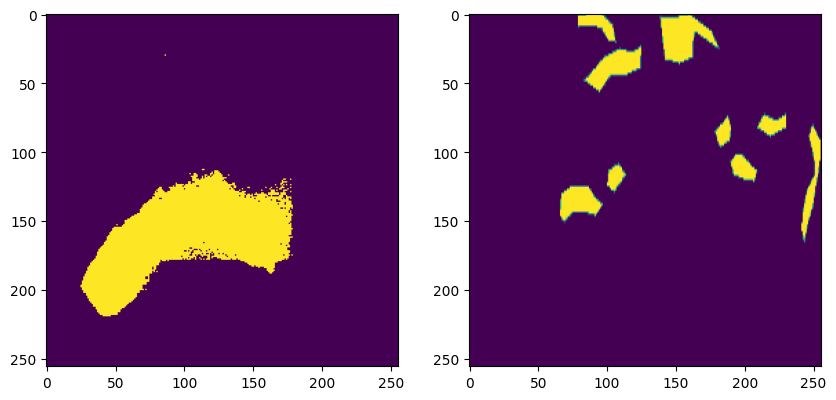

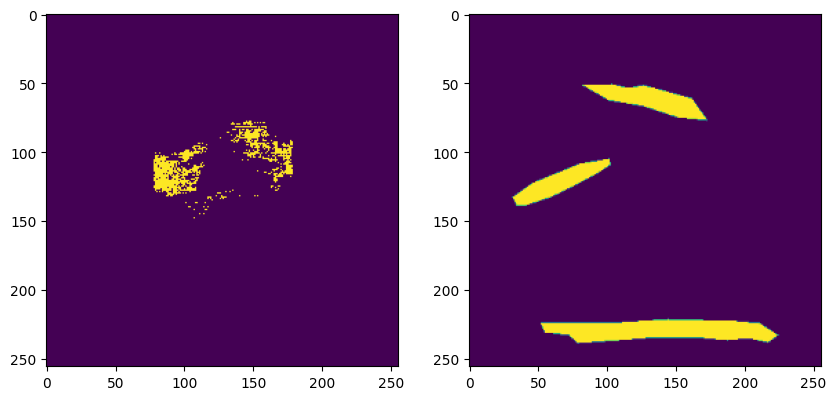

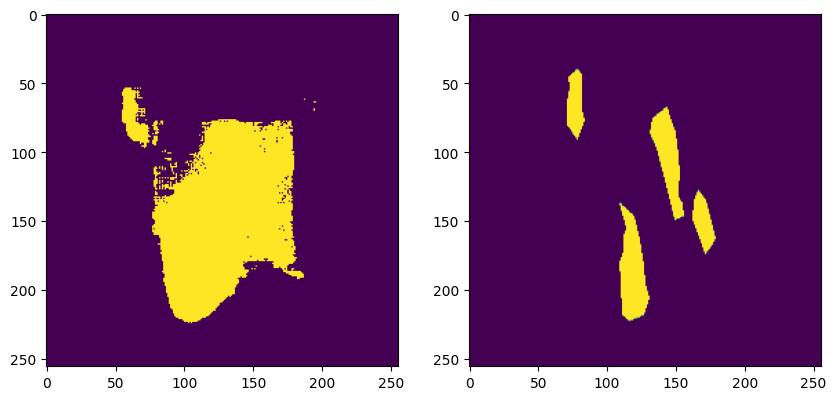

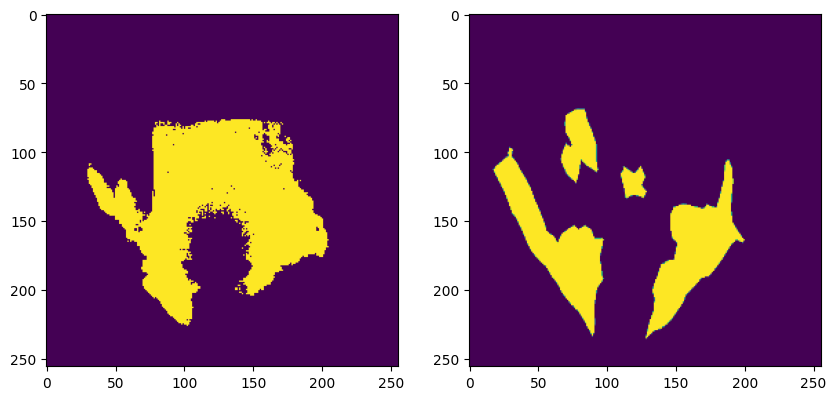

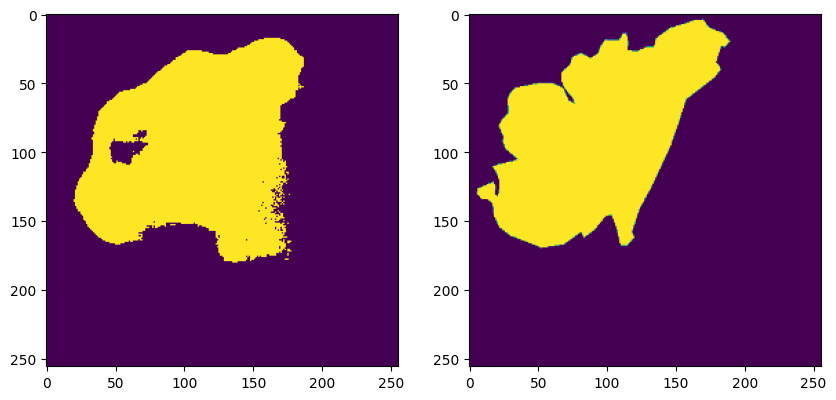

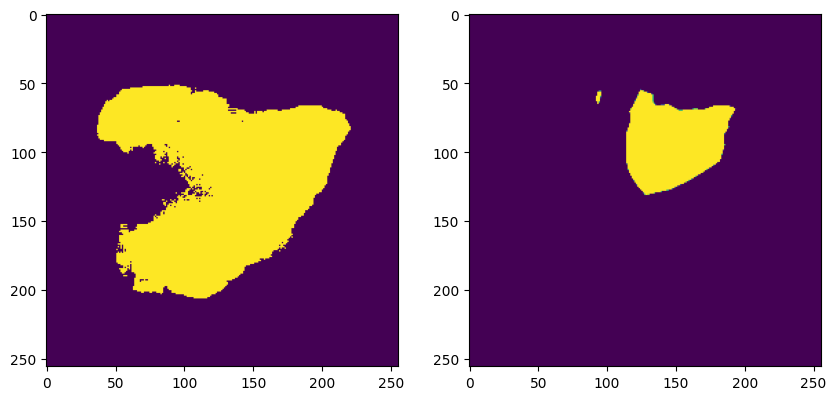

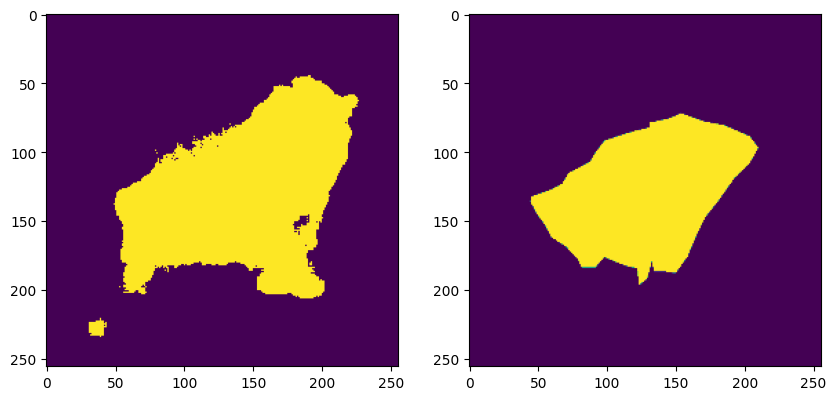

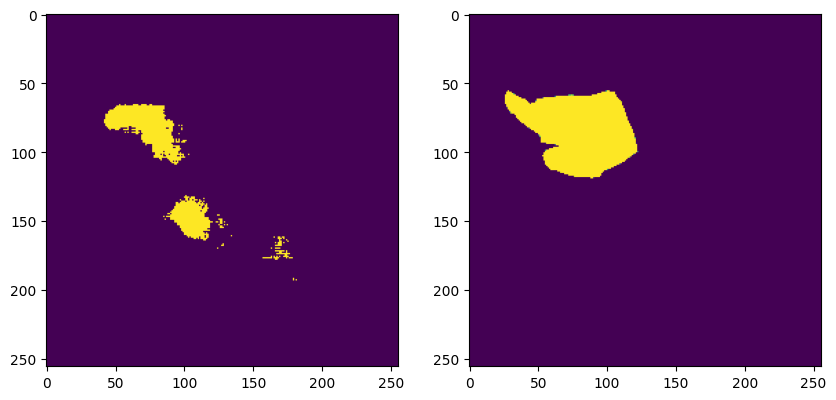

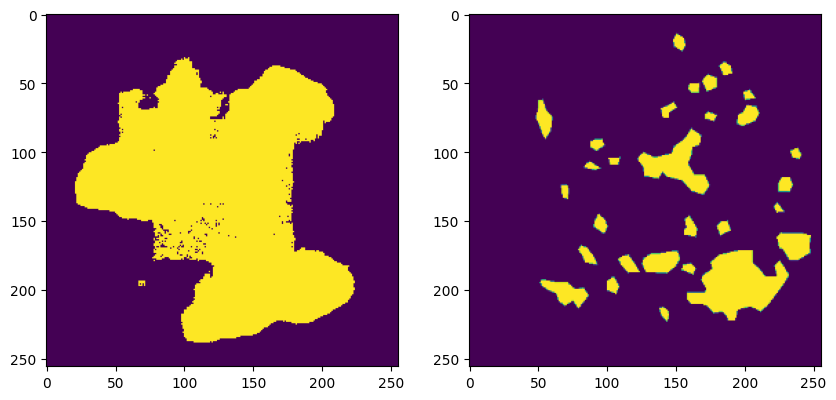

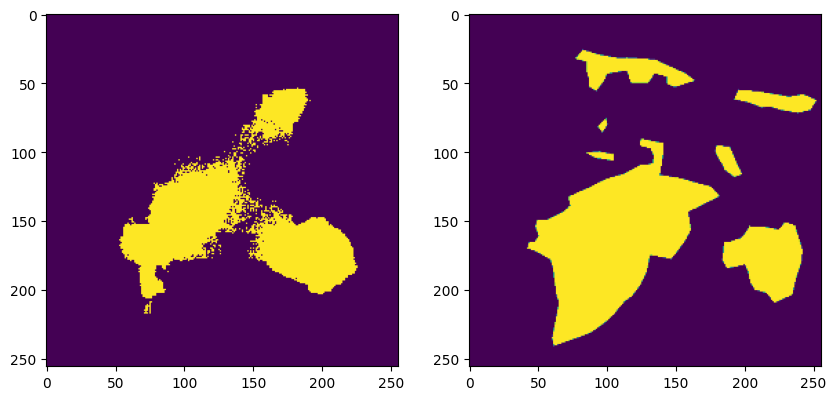

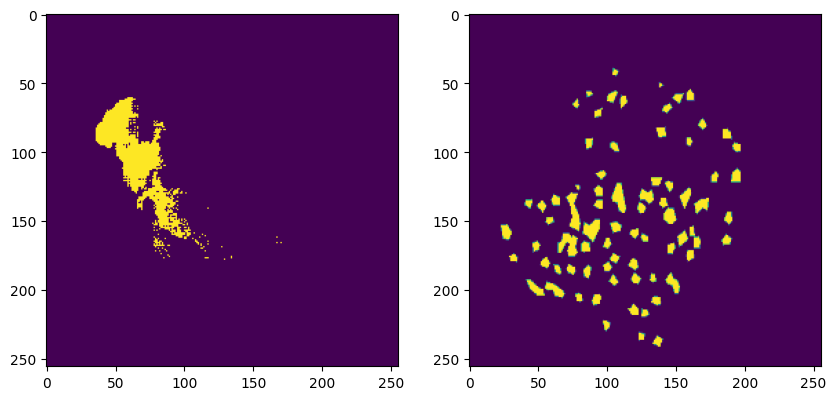

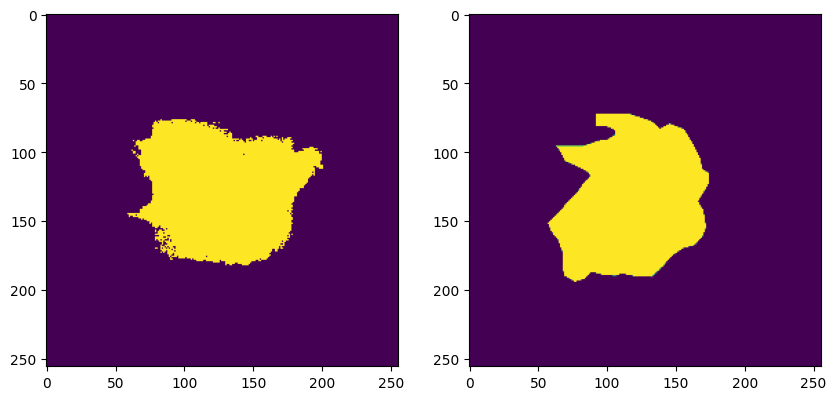

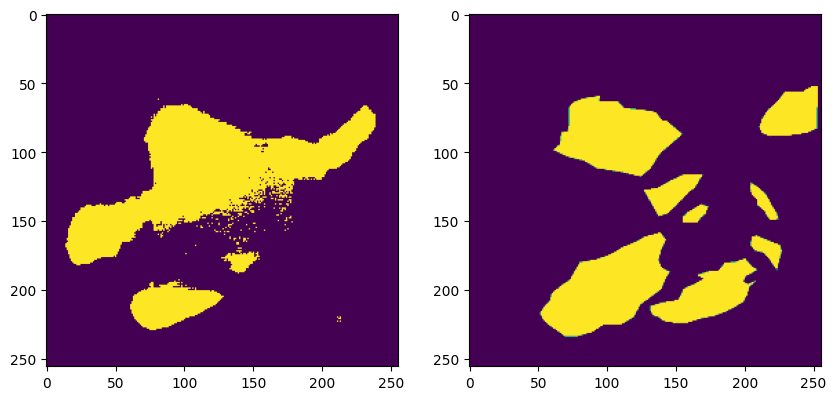

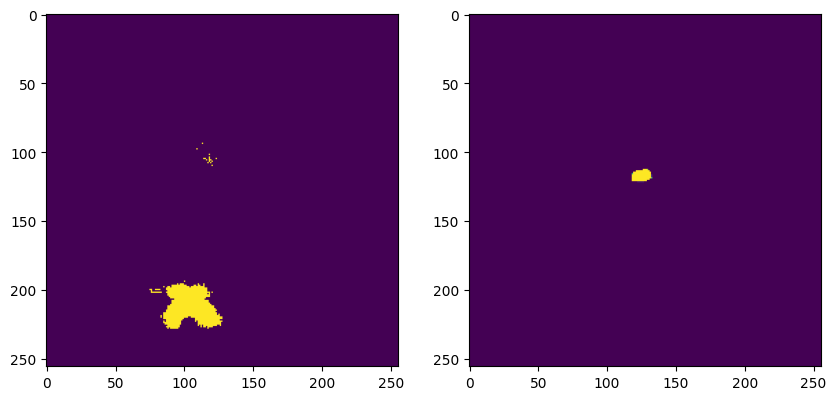

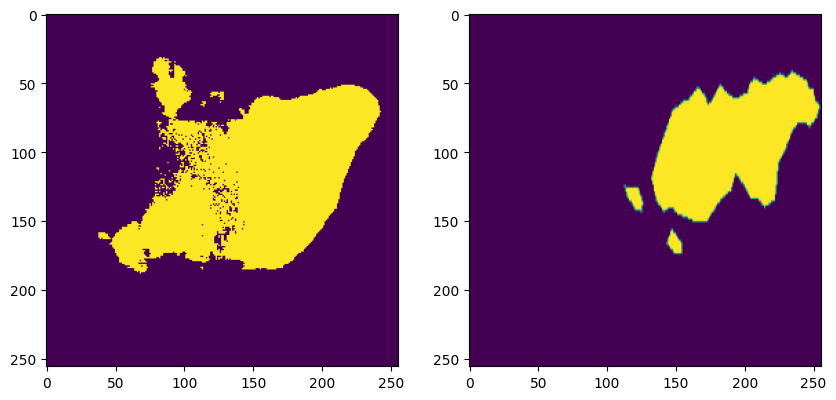

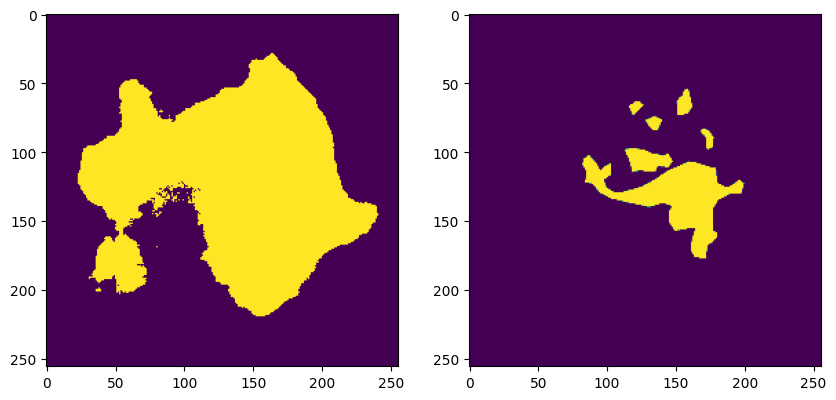

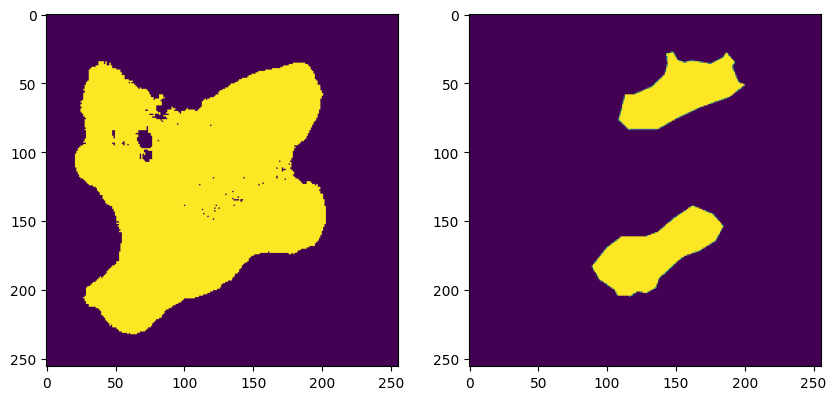

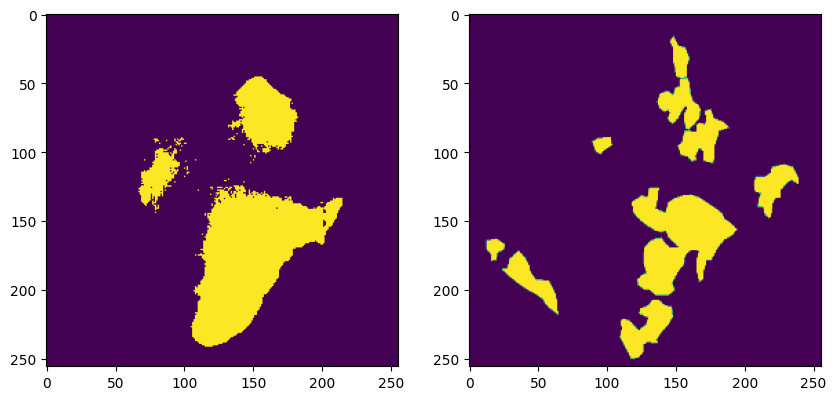

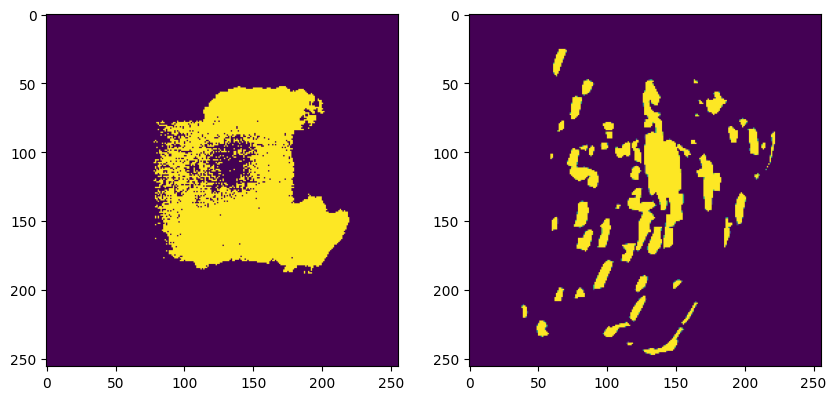

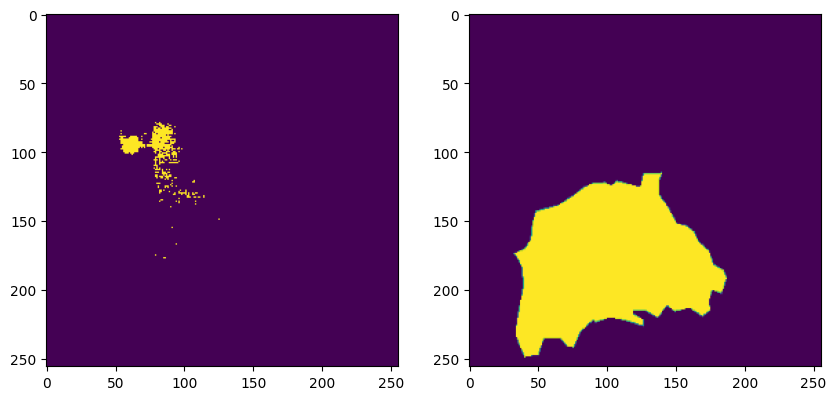

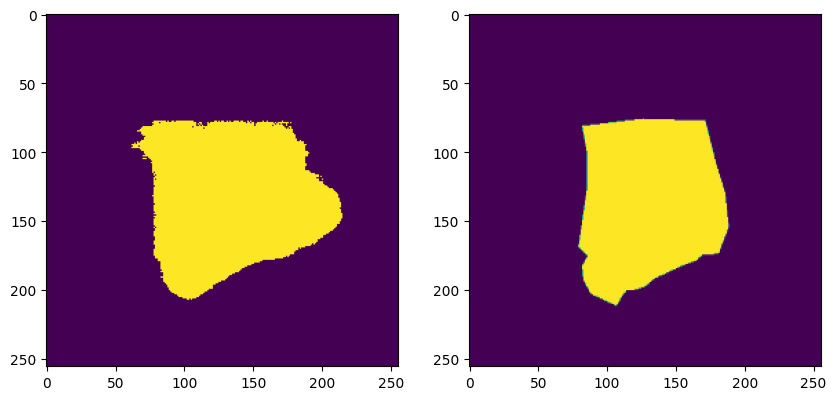

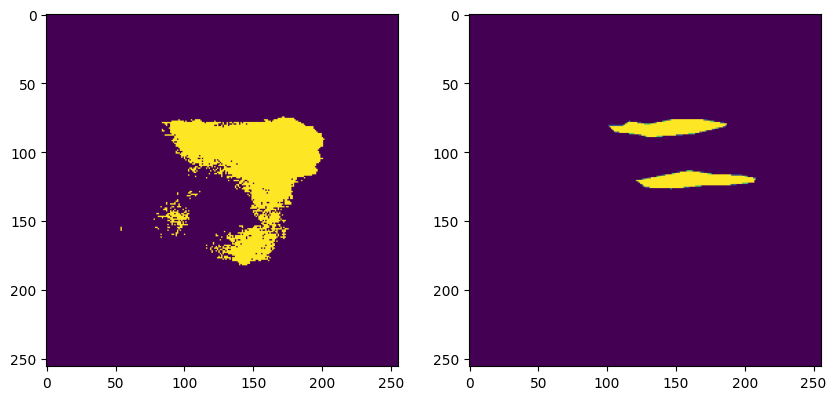

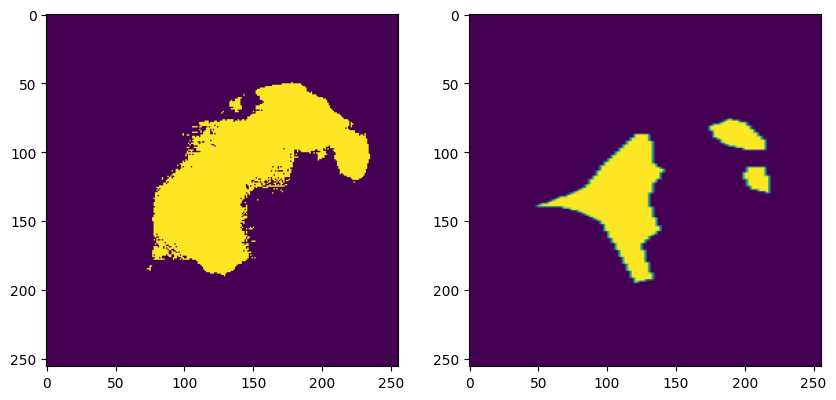

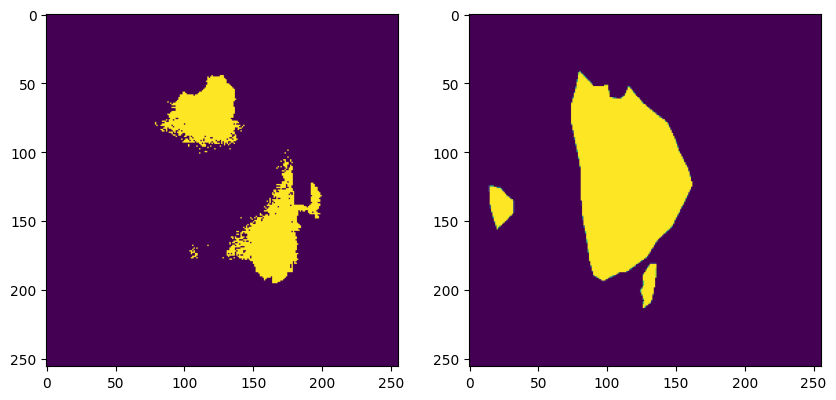

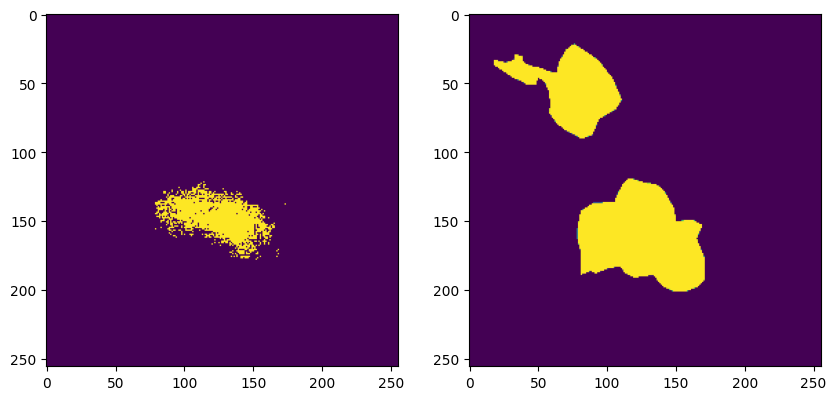

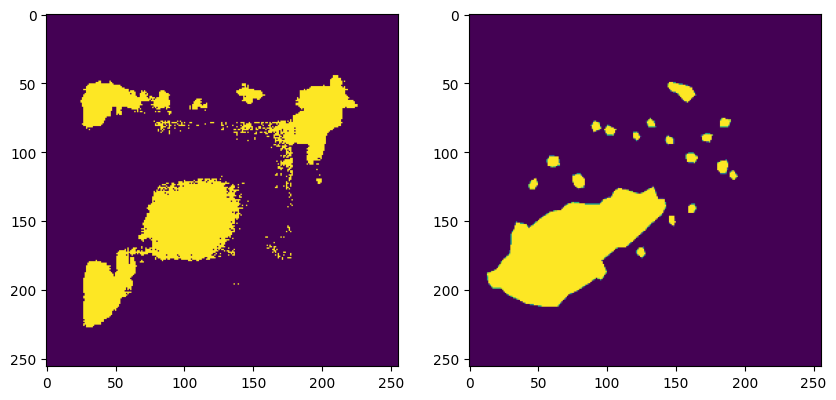

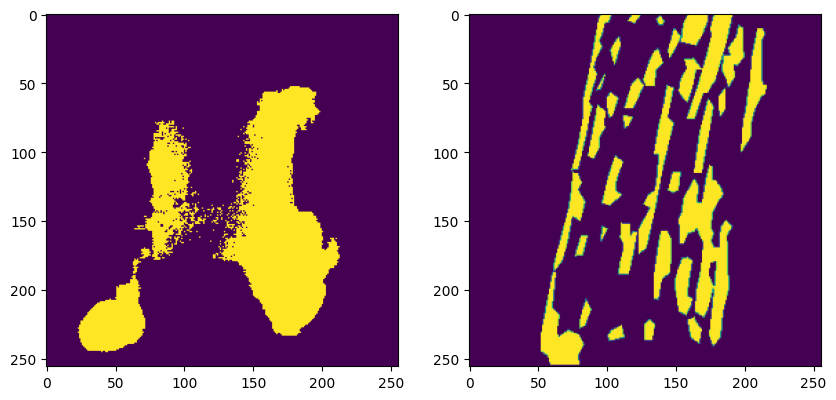

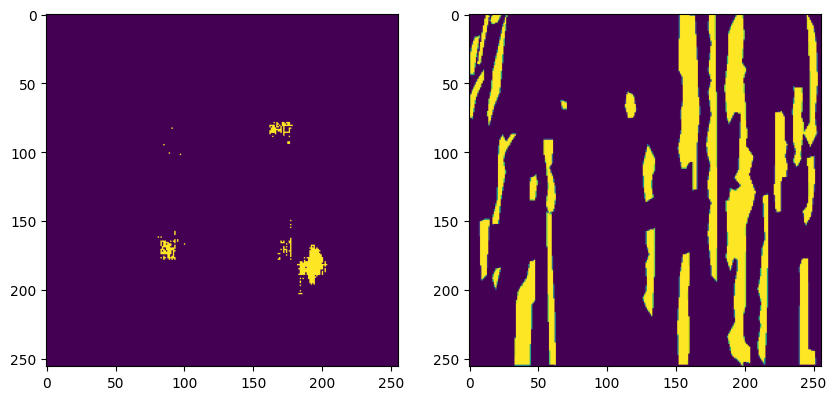

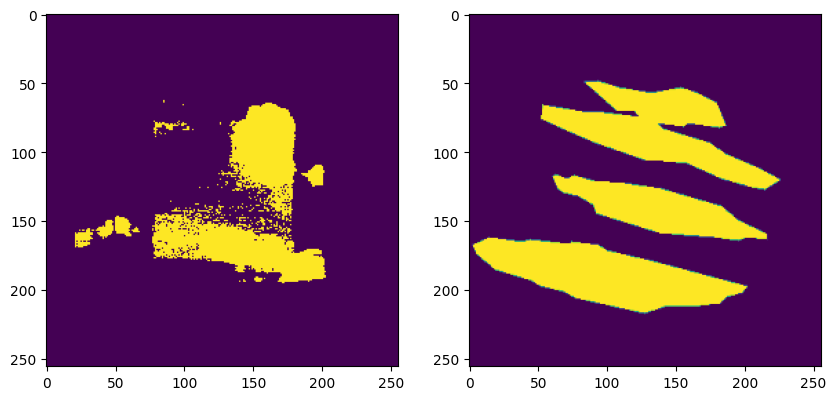

In [26]:
for (images, masks) in test_dataloader:
        images = images.to(device)

        outputs = unet(images)
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > 0.5).float()

        outputs = outputs.to('cpu').detach().numpy()

        fig, axs = plt.subplots(1, 2, figsize=(10, 10))


        axs[0].imshow(outputs[0][0])
        axs[1].imshow(masks[0][0])
        plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()